In [45]:
# This notebook is used to
# 1. Refine the classifiers to mitigate data imbalance
# 2. Create ensemble classifier
# 3. Perform feature ablation

import pickle5
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

plt.style.use('bmh')
mpl.rcParams.update({
    "grid.linestyle" : "dashed",
    "axes.facecolor" : "white",
    "axes.spines.top" : False,
    "axes.spines.right" : False,
    "legend.frameon" : False,
    "figure.figsize" : (8, 5),
    "figure.dpi" : 300,
})

# suppress sklearn deprecated warnings
import warnings
def warn(*args, **kwargs): pass
warnings.warn = warn

### Read Data

In [52]:
# TODO make test for dataset with creatina column
# Dataset without thyroid = 18 features (including survive7y)
# Dataset with thyroid = 27 features (including survive7y)
# With columns that have missing values, 23 and 32
# Default 18
n_features = 23
extra_path = n_features != 27 and n_features != 18
dropped_na_key = "dropped_na/"
mean_key = "mean/"
path = f"data/{n_features}features/{mean_key if extra_path else '' }"
path_models = f"models/{n_features}features/{mean_key if extra_path else '' }"
path_images = f"figures/{n_features}features/{mean_key if extra_path else '' }"
print(path_models)
print(path)

models/23features/mean/
data/23features/mean/


In [53]:
# Read data
df_train = pd.read_csv(f"{path}train.csv", index_col=0)
df_valid = pd.read_csv(f"{path}valid.csv", index_col=0)
df_test = pd.read_csv(f"{path}test.csv", index_col=0)

train, valid, test = df_train.to_numpy(), df_valid.to_numpy(), df_test.to_numpy()
X_train, y_train = train[:, :-1], train[:, -1]
X_valid, y_valid = valid[:, :-1], valid[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
feat_names = list(df_train.columns)

from collections import Counter
print(Counter(y_train))
print(Counter(y_valid))
print(Counter(y_test))

# All the numerical features that can be standarditazed
from utils import get_preprocess_std_num
preprocess_std = get_preprocess_std_num(feat_names)
preprocess_std_all = StandardScaler()

# Preprocessed ready-to-use train and valid set
process_tmp = preprocess_std.fit(X_train)
X_train_std = process_tmp.transform(X_train)
X_valid_std = process_tmp.transform(X_valid)

Counter({1.0: 3494, 0.0: 505})
Counter({1.0: 1165, 0.0: 169})
Counter({1.0: 1165, 0.0: 169})


In [55]:
from ensemble import build_ensemble, evaluate_ensemble, predict_ensemble

# Run file 3.2 to find the best ensemble if this list is empty
# Top model: 32 parameter, dropped na, model -> nn
top_model = ["xgb","gb","nn","rf"]

ensemble = build_ensemble(top_model, path_models)
names = list(map(lambda x: x[0], ensemble))
ensemble = list(map(lambda x: x[1], ensemble))
evaluate_ensemble(ensemble, X_valid, y_valid)
evaluate_ensemble(ensemble, X_test, y_test)

              precision    recall  f1-score   support

         0.0      0.602     0.438     0.507       169
         1.0      0.922     0.958     0.939      1165

    accuracy                          0.892      1334
   macro avg      0.762     0.698     0.723      1334
weighted avg      0.881     0.892     0.885      1334

auroc 0.840
brier 0.085
[[  74   95]
 [  49 1116]]
              precision    recall  f1-score   support

         0.0      0.576     0.337     0.425       169
         1.0      0.909     0.964     0.936      1165

    accuracy                          0.885      1334
   macro avg      0.743     0.651     0.681      1334
weighted avg      0.867     0.885     0.871      1334

auroc 0.841
brier 0.087
[[  57  112]
 [  42 1123]]


(0.6506133021814764, 0.9358333333333333, 0.11544227886056972)

0.910977744436109
0.8920539730134932
0.8845577211394303


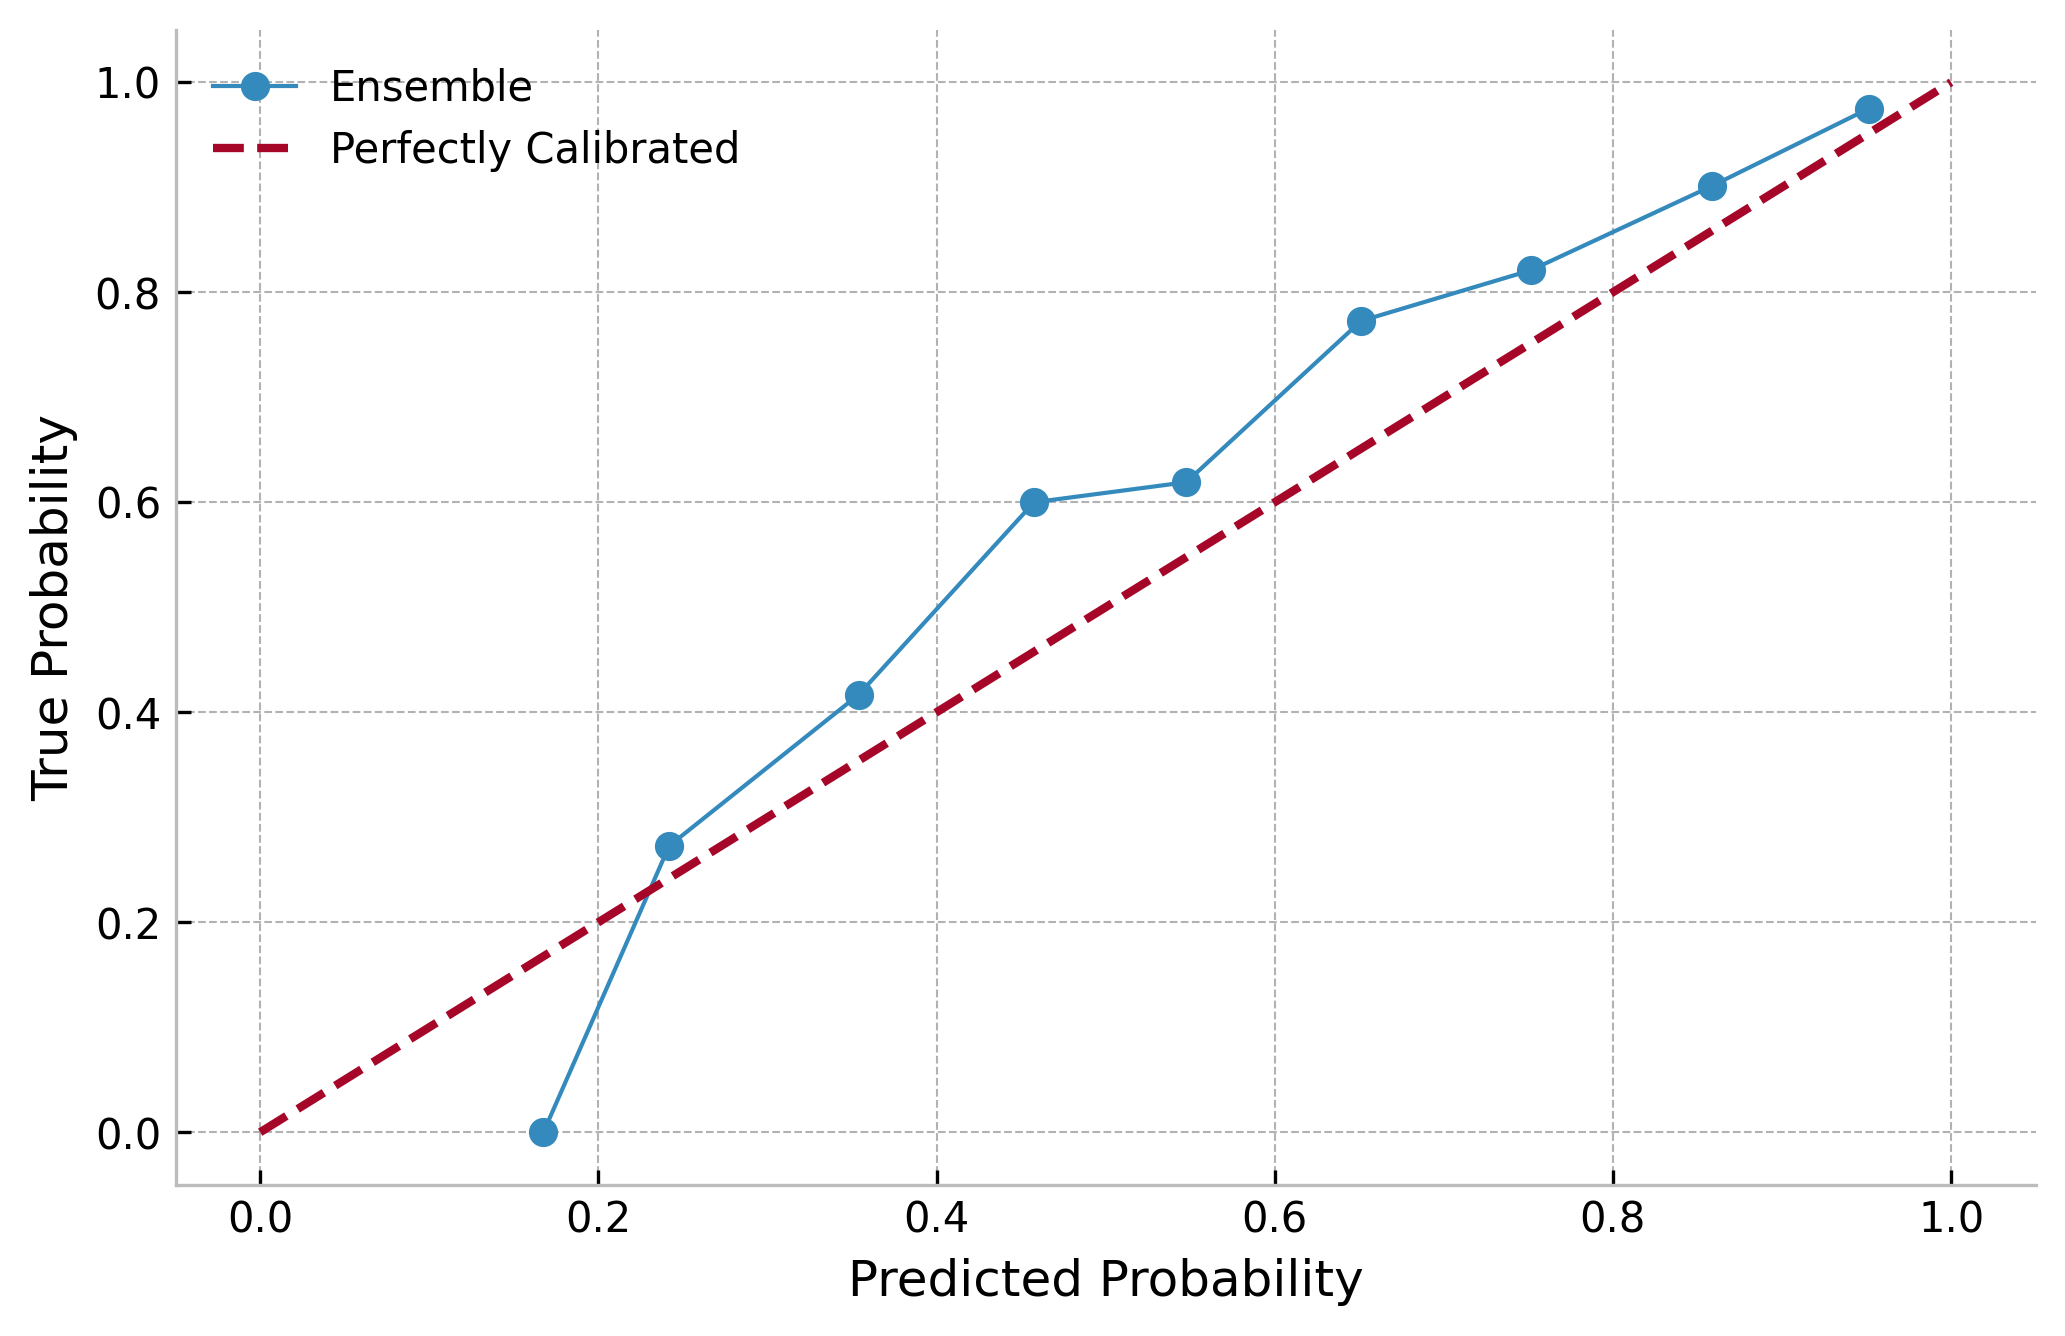

In [56]:
from sklearn.calibration import calibration_curve
train_prob, train_pred = predict_ensemble(ensemble, X_train, y_train)
valid_prob, valid_pred = predict_ensemble(ensemble, X_valid, y_valid)
test_prob, test_pred = predict_ensemble(ensemble, X_test, y_test)

print(sum(y_train == train_pred) / len(df_train))
print(sum(y_valid == valid_pred) / len(df_valid))
print(sum(y_test == test_pred) / len(df_test))

df_train["ModelOutput"] = train_prob[:, 1]
df_valid["ModelOutput"] = valid_prob[:, 1]
df_test["ModelOutput"] = test_prob[:, 1]
true_pos, pred_pos = calibration_curve(y_test, test_prob[:, 1], n_bins=10)
plt.plot(pred_pos,
         true_pos, 
         marker='o', 
         linewidth=1, 
         label='Ensemble')
plt.plot([0, 1], 
         [0, 1], 
         linestyle='--', 
         label='Perfectly Calibrated')

# plt.title('Probability Calibration Curve')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend(loc='best')

#plt.savefig(f"{path_images}calibration1.png")
#from PIL import Image
#png2 = Image.open("figures/calibration1.png", mode = "w")
#png2.save("figures/calibration1.tiff")

In [7]:
df_cvd = pd.read_csv("./data/raw/data_cvd.csv", index_col=0, decimal='.')
df_cvd["Follow Up Data"] = pd.to_datetime(df_cvd["Follow Up Data"])
df_cvd["Data prelievo"] = pd.to_datetime(df_cvd["Data prelievo"])
df_cvd["Elapsed"] = (df_cvd["Follow Up Data"] - df_cvd["Data prelievo"]).map(lambda x: x.days // 365)
df_plot = df_test.join(df_cvd["Elapsed"])

assert len(df_plot) == len(df_test)

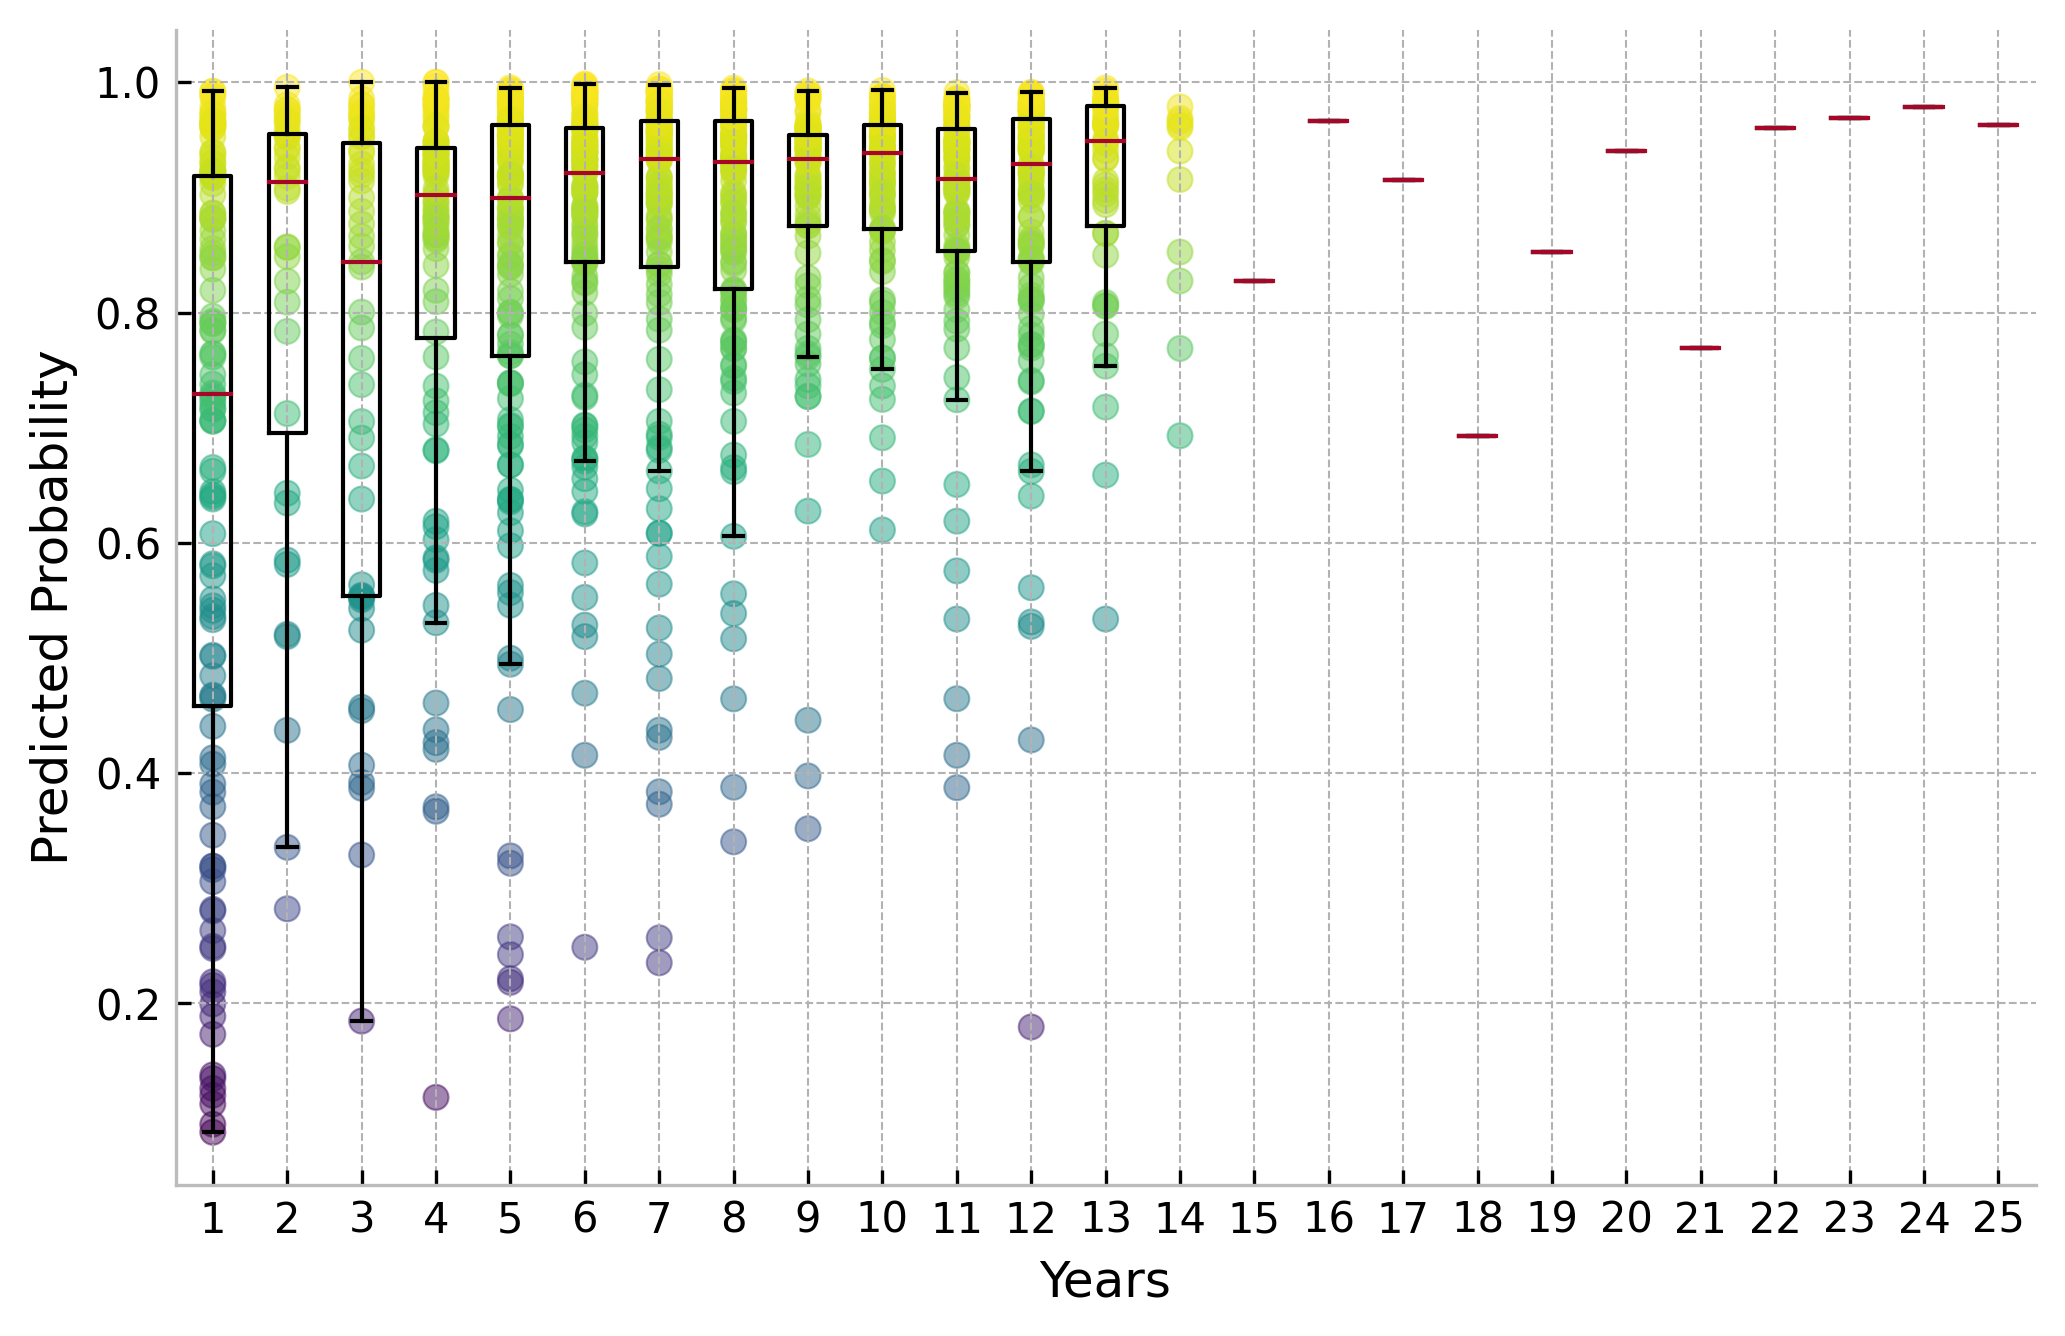

In [14]:
plt.figure(rasterized=True)

boxes = list(map(lambda x: list(x[1].values), list(df_plot.groupby("Elapsed")["ModelOutput"])))
boxes = boxes[:-1] + [[]] + boxes[-1]
plt.boxplot(boxes, showfliers=False)

n = 0.
noise = (np.random.rand(len(df_plot)) * n) - (n / 2)
plt.scatter(df_plot["Elapsed"]+1+noise, df_plot["ModelOutput"], c=df_plot["ModelOutput"], alpha=0.5)

plt.xlabel("Years")
plt.ylabel("Predicted Probability")
# plt.xticks(range(18), [f"n={len(box)}" for box in boxes])
plt.savefig(f"{path_images}calibration.png")
#from PIL import Image
#png2 = Image.open("figures/calibration.png")
#png2.save("figures/calibration.tiff")

### Feature Ablation

In [57]:
from sklearn.inspection import permutation_importance
def get_univariate_ablation_results(X, y):
    """For each feature we set it to its mean value and save the resulting metrics"""

    features = df_valid.columns
    accuracy, auroc, f1_death, f1_survive, f1_macro = [], [], [], [], []
    for i, _ in enumerate(range(X_valid.shape[1])):
        X_copy = X.copy()
        # X_copy.shape[0] returns the number of rows in our test set, X.shape[1] the number of columns
        X_copy[:, i] = np.mean(X_copy[:, i]) * np.ones(X_copy.shape[0])
        # Predict the ensemble with the values replaced with the mean
        y_proba, y_pred = predict_ensemble(ensemble, X_copy, y)

        accuracy.append((features[i], round(accuracy_score(y, y_pred), 3)))
        auroc.append((features[i], round(roc_auc_score(y, y_proba[:, 1]), 3)))
        f1_death.append((features[i], round(f1_score(y, y_pred, pos_label=0), 3)))
        f1_survive.append((features[i], round(f1_score(y, y_pred, pos_label=1), 3)))
        f1_macro.append((features[i], round(f1_score(y, y_pred, average="macro"), 3)))
    
    return accuracy, auroc, f1_death, f1_survive, f1_macro


def get_multivariate_ablation_results(feat_clusters, X, y, skip_single=False):
    """For each cluster of features, we set each feature of a group to its mean and save the resulting metrics"""

    accuracy, auroc, f1_death, f1_survive, f1_macro = [], [], [], [], []
    for feat_cluster in feat_clusters:
        if skip_single and (len(feat_cluster)) == 1:
            continue

        # Create a copy of the dataset
        X_copy = X.copy()
        t = []
        for feat in feat_cluster:
            p = feat_names.index(feat)
            t.append(p)
            X_copy[:, p] = np.mean(X_copy[:, p]) * np.ones(X_copy.shape[0])

        # Predict
        y_proba, y_pred = predict_ensemble(ensemble, X_copy, y)
        accuracy.append(round(accuracy_score(y, y_pred), 3))
        auroc.append(round(roc_auc_score(y, y_proba[:, 1]), 3))
        f1_death.append(round(f1_score(y, y_pred, pos_label=0), 3))
        f1_survive.append(round(f1_score(y, y_pred, pos_label=1), 3))
        f1_macro.append(round(f1_score(y, y_pred, average="macro"), 3))
    
    return accuracy, auroc, f1_death, f1_survive, f1_macro

In [58]:
# Univariate ablation
accuracy, auroc, f1_death, f1_survive, f1_macro = get_univariate_ablation_results(X_test, y_test)
ensemble_f1_score = round(f1_score(y_test, test_pred, average="macro"), 3)
p = pd.DataFrame({
    "auroc": [x[1] for x in auroc], 
    "f1_macro": [x[1] for x in f1_macro],
    "importance" : [ ensemble_f1_score / x[1] for x in f1_macro],
    }, index=feat_names[:-1]).sort_values("importance",ascending = False)
p.to_csv(f"{path_models}extra_ablation_uni_test.csv", float_format = '%.5f')

In [65]:
# Multivariate hierarchical ablation
with open(f"{path_results}feat_cluster_hier.df", "rb") as f:
    df_clusters = pickle5.load(f)
print(df_clusters)
accuracy, auroc, f1_death, f1_survive, f1_macro = get_multivariate_ablation_results(df_clusters, X_test, y_test)
p = pd.DataFrame({"cluster": df_clusters, "auroc": auroc, "f1_macro": f1_macro, "importance" : [ ensemble_f1_score / x for x in f1_macro] })
p.to_csv("multivariate_ablation_hier_nomeds.csv", float_format = '%.5f')

0    [Age, Diabetes\nHistory of diabetes, Hypertens...
1         [Gender (Male = 1), Smoke\nHistory of smoke]
2    [Previous CABG, Previous PCI, Previous Myocard...
3    [Angina, Angiography, Vessels, Documented rest...
4                        [Acute Myocardial Infarction]
Name: Feature, dtype: object
